In [1]:
import spacy
import gensim
import pandas as pd
import nltk
import numpy as np
import seaborn as sn
import re
import string
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from gensim.models.fasttext import FastText
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from MeanVectorizer import MeanEmbeddingVectorizer
from sklearn.utils import resample

nlp = spacy.blank('id')
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_excel("pemilu.xlsx")
df.head()

,id_pembuat,id_status,nama_pembuat,teks_status,gambar_status,url_komentar,waktu_status,id_komentar,id_user_komen,komentar,waktu_komen,label
0,23383061178,23383061178_10152076252911179,Bang Nafie,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076253441179,794948677210695,Oke pak boss!!,2014-06-05 03:55:15,positif
1,23383061178,23383061178_10152076252911179,Sumy Kakasyi Suhaimy,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076253906179,355122887988412,Jangan dusta,2014-06-05 03:55:29,negatif
2,23383061178,23383061178_10152076252911179,Roberto Red,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076253996179,297825977080553,PROBOWO is the WINNER of PEMILU 2014,2014-06-05 03:55:32,positif
3,23383061178,23383061178_10152076252911179,Sugiarman Arman,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076254066179,298708870333739,ilmu padi,2014-06-05 03:55:35,netral
4,23383061178,23383061178_10152076252911179,Rio Corps Taruna,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076254216179,1523715244533780,Hidup Pak Prabowo ..,2014-06-05 03:55:42,positif


In [3]:
komentar = df['komentar'].astype(str)

# Huruf kecil
komentar = komentar.apply(lambda x: x.lower())

# Hapus URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

# Hapus angka
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

# Hapus tanda baca
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Hapus diluar alphabet dan numeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

# Tokenizing data
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

,id_pembuat,id_status,nama_pembuat,teks_status,gambar_status,url_komentar,waktu_status,id_komentar,id_user_komen,komentar,waktu_komen,label
0,23383061178,23383061178_10152076252911179,Bang Nafie,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076253441179,794948677210695,"[oke, pak, boss]",2014-06-05 03:55:15,positif
1,23383061178,23383061178_10152076252911179,Sumy Kakasyi Suhaimy,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076253906179,355122887988412,"[jangan, dusta]",2014-06-05 03:55:29,negatif
2,23383061178,23383061178_10152076252911179,Roberto Red,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076253996179,297825977080553,"[probowo, is, the, winner, of, pemilu]",2014-06-05 03:55:32,positif
3,23383061178,23383061178_10152076252911179,Sugiarman Arman,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076254066179,298708870333739,"[ilmu, padi]",2014-06-05 03:55:35,netral
4,23383061178,23383061178_10152076252911179,Rio Corps Taruna,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076254216179,1523715244533780,"[hidup, pak, prabowo]",2014-06-05 03:55:42,positif
...,...,...,...,...,...,...,...,...,...,...,...,...
3359,249750628565406,249750628565406_276917339182068,Anita Rizkia,"Dukungan anda semua adalah amanah, dan apapun ...",https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/249750628565406/posts...,2014-07-09 03:19:51,276891429184659_276927652514370,967613349931842,"[salam, jari]",2014-07-09 03:25:45,positif
3360,249750628565406,249750628565406_276917339182068,Ari Bin Abu Bakar,"Dukungan anda semua adalah amanah, dan apapun ...",https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/249750628565406/posts...,2014-07-09 03:19:51,276891429184659_276918865848582,773356856051191,"[jujur, ketika, ane, membuka, surat, suara, ta...",2014-07-09 03:21:40,negatif
3361,249750628565406,249750628565406_276917339182068,Agek James,"Dukungan anda semua adalah amanah, dan apapun ...",https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/249750628565406/posts...,2014-07-09 03:19:51,276891429184659_276921042515031,710343512387954,"[bapak, jokowi, kami, semua, rakyat, ingin, ba...",2014-07-09 03:24:02,positif
3362,249750628565406,249750628565406_276917339182068,ChairudinDr Humaniora,"Dukungan anda semua adalah amanah, dan apapun ...",https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/249750628565406/posts...,2014-07-09 03:19:51,276891429184659_276931322514003,10152763210314600,"[tanda, alam, pemilu, day, on, juli, hasil, je...",2014-07-09 03:26:36,positif


In [4]:
df['label'].value_counts()

positif    2912
negatif     332
netral      120
Name: label, dtype: int64

In [5]:
df = df[df.komentar.astype(bool)]

df_pos = df[df['label'] == 'positif']
X_pos_text = df_pos['komentar']
y_pos_label = df_pos['label']

df_neg = df[df['label'] == 'negatif']
X_neg_text = df_neg['komentar']
y_neg_label = df_neg['label']

df_net = df[df['label'] == 'netral']
X_net_text = df_net['komentar']
y_net_label = df_net['label']

In [6]:
X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(X_pos_text, y_pos_label, test_size=0.2, random_state=1, stratify=y_pos_label)
X_neg_train, X_neg_test, y_neg_train, y_neg_test = train_test_split(X_neg_text, y_neg_label, test_size=0.2, random_state=1, stratify=y_neg_label)
X_net_train, X_net_test, y_net_train, y_net_test = train_test_split(X_net_text, y_net_label, test_size=0.2, random_state=1, stratify=y_net_label)

In [7]:
X_neg_train_up = resample(X_neg_train, replace=True, n_samples=int(len(X_pos_train)))
y_net_train_up = resample(y_net_train, replace=True, n_samples=int(len(y_pos_train)))

X_net_train_up = resample(X_net_train, replace=True, n_samples=int(len(X_pos_train)))
y_neg_train_up = resample(y_neg_train, replace=True, n_samples=int(len(y_pos_train)))

In [8]:
X_train = pd.concat([X_pos_train, X_neg_train_up])
X_train = pd.concat([X_train, X_net_train_up])
y_train = pd.concat([y_pos_train, y_neg_train_up])
y_train = pd.concat([y_train, y_net_train_up])

X_test = pd.concat([X_pos_test, X_neg_test])
X_test = pd.concat([X_test, X_net_test])
y_test = pd.concat([y_pos_test, y_neg_test])
y_test = pd.concat([y_test, y_net_test])

In [9]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [10]:
print(y_train.value_counts())

positif    2320
negatif    2320
netral     2320
Name: label, dtype: int64


In [11]:
model = FastText.load('Model/XGBUpSampling.bin')

In [12]:
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [13]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [14]:
lc = preprocessing.LabelEncoder()
lc.fit(y_train)

LabelEncoder()

In [15]:
y_train_enc=lc.transform(y_train)
y_test_enc=lc.transform(y_test)

In [16]:
train=xgb.DMatrix(X_train_vector,label=y_train_enc)
test=xgb.DMatrix(X_test_vector,label=y_test_enc)

In [17]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.5
# Max Depth:  12
# Subsample:  0.4
# Colsample Bytree:  0.3
# Alpha:  0.01
# Lamda:  2
# Min Child Weight:  3
# Number of Trees:  1000

param['num_class']=len(set(y_train))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.5
param['max_depth'] = 12
param['subsample'] = 0.4
param['colsample_bytree'] = 0.3
param['reg_alpha'] = 0.01
param['reg_lambda'] = 2
param['min_child_weight'] = 3
num_round = 1000

watchlist = [(train, 'train'), (test, 'test')]
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.08836	test-merror:0.32036
[1]	train-merror:0.05172	test-merror:0.24850
[2]	train-merror:0.03851	test-merror:0.24102
[3]	train-merror:0.02945	test-merror:0.22006
[4]	train-merror:0.02629	test-merror:0.23204
[5]	train-merror:0.02241	test-merror:0.22904
[6]	train-merror:0.02112	test-merror:0.20659
[7]	train-merror:0.02069	test-merror:0.20509
[8]	train-merror:0.01954	test-merror:0.18862
[9]	train-merror:0.01782	test-merror:0.18563
[10]	train-merror:0.01796	test-merror:0.18563
[11]	train-merror:0.01710	test-merror:0.17964
[12]	train-merror:0.01825	test-merror:0.18563
[13]	train-merror:0.01810	test-merror:0.19012
[14]	train-merror:0.01767	test-merror:0.18713
[15]	train-merror:0.01695	test-merror:0.18413
[16]	train-merror:0.01710	test-merror:0.17964
[17]	train-merror:0.01724	test-merror:0.17365
[18]	train-merror:0.01652	test-merror:0.17515
[19]	train-merror:0.01652	test-merror:0.17515
[20]	train-merror:0.01609	test-merror:0.17814
[21]	train-merror:0.01609	test-merror:0.1781

[177]	train-merror:0.01351	test-merror:0.15269
[178]	train-merror:0.01351	test-merror:0.15269
[179]	train-merror:0.01351	test-merror:0.15269
[180]	train-merror:0.01336	test-merror:0.15269
[181]	train-merror:0.01351	test-merror:0.15269
[182]	train-merror:0.01351	test-merror:0.15269
[183]	train-merror:0.01351	test-merror:0.15269
[184]	train-merror:0.01351	test-merror:0.15269
[185]	train-merror:0.01351	test-merror:0.15269
[186]	train-merror:0.01351	test-merror:0.15269
[187]	train-merror:0.01351	test-merror:0.15269
[188]	train-merror:0.01351	test-merror:0.15419
[189]	train-merror:0.01351	test-merror:0.15419
[190]	train-merror:0.01351	test-merror:0.15419
[191]	train-merror:0.01351	test-merror:0.15419
[192]	train-merror:0.01351	test-merror:0.15419
[193]	train-merror:0.01351	test-merror:0.15269
[194]	train-merror:0.01351	test-merror:0.15269
[195]	train-merror:0.01351	test-merror:0.15269
[196]	train-merror:0.01351	test-merror:0.15269
[197]	train-merror:0.01351	test-merror:0.15269
[198]	train-m

[352]	train-merror:0.01336	test-merror:0.14671
[353]	train-merror:0.01336	test-merror:0.14671
[354]	train-merror:0.01336	test-merror:0.14671
[355]	train-merror:0.01336	test-merror:0.14671
[356]	train-merror:0.01336	test-merror:0.14671
[357]	train-merror:0.01336	test-merror:0.14671
[358]	train-merror:0.01336	test-merror:0.14671
[359]	train-merror:0.01336	test-merror:0.14671
[360]	train-merror:0.01336	test-merror:0.14671
[361]	train-merror:0.01336	test-merror:0.14671
[362]	train-merror:0.01336	test-merror:0.14671
[363]	train-merror:0.01336	test-merror:0.14671
[364]	train-merror:0.01336	test-merror:0.14671
[365]	train-merror:0.01336	test-merror:0.14671
[366]	train-merror:0.01336	test-merror:0.14671
[367]	train-merror:0.01336	test-merror:0.14671
[368]	train-merror:0.01336	test-merror:0.14671
[369]	train-merror:0.01336	test-merror:0.14671
[370]	train-merror:0.01336	test-merror:0.14671
[371]	train-merror:0.01336	test-merror:0.14671
[372]	train-merror:0.01336	test-merror:0.14671
[373]	train-m

[527]	train-merror:0.01336	test-merror:0.14671
[528]	train-merror:0.01336	test-merror:0.14671
[529]	train-merror:0.01336	test-merror:0.14671
[530]	train-merror:0.01336	test-merror:0.14671
[531]	train-merror:0.01336	test-merror:0.14671
[532]	train-merror:0.01336	test-merror:0.14671
[533]	train-merror:0.01336	test-merror:0.14671
[534]	train-merror:0.01336	test-merror:0.14671
[535]	train-merror:0.01336	test-merror:0.14671
[536]	train-merror:0.01336	test-merror:0.14671
[537]	train-merror:0.01336	test-merror:0.14671
[538]	train-merror:0.01336	test-merror:0.14671
[539]	train-merror:0.01336	test-merror:0.14671
[540]	train-merror:0.01336	test-merror:0.14820
[541]	train-merror:0.01336	test-merror:0.14671
[542]	train-merror:0.01336	test-merror:0.14820
[543]	train-merror:0.01336	test-merror:0.14820
[544]	train-merror:0.01336	test-merror:0.14820
[545]	train-merror:0.01336	test-merror:0.14820
[546]	train-merror:0.01336	test-merror:0.14820
[547]	train-merror:0.01336	test-merror:0.14820
[548]	train-m

[702]	train-merror:0.01336	test-merror:0.14371
[703]	train-merror:0.01336	test-merror:0.14371
[704]	train-merror:0.01336	test-merror:0.14371
[705]	train-merror:0.01336	test-merror:0.14371
[706]	train-merror:0.01336	test-merror:0.14371
[707]	train-merror:0.01336	test-merror:0.14371
[708]	train-merror:0.01336	test-merror:0.14371
[709]	train-merror:0.01336	test-merror:0.14371
[710]	train-merror:0.01336	test-merror:0.14371
[711]	train-merror:0.01336	test-merror:0.14371
[712]	train-merror:0.01336	test-merror:0.14371
[713]	train-merror:0.01336	test-merror:0.14371
[714]	train-merror:0.01336	test-merror:0.14371
[715]	train-merror:0.01336	test-merror:0.14371
[716]	train-merror:0.01336	test-merror:0.14371
[717]	train-merror:0.01336	test-merror:0.14371
[718]	train-merror:0.01336	test-merror:0.14371
[719]	train-merror:0.01336	test-merror:0.14371
[720]	train-merror:0.01336	test-merror:0.14371
[721]	train-merror:0.01336	test-merror:0.14371
[722]	train-merror:0.01336	test-merror:0.14371
[723]	train-m

[877]	train-merror:0.01336	test-merror:0.14371
[878]	train-merror:0.01336	test-merror:0.14371
[879]	train-merror:0.01336	test-merror:0.14371
[880]	train-merror:0.01336	test-merror:0.14371
[881]	train-merror:0.01336	test-merror:0.14371
[882]	train-merror:0.01336	test-merror:0.14371
[883]	train-merror:0.01336	test-merror:0.14371
[884]	train-merror:0.01336	test-merror:0.14371
[885]	train-merror:0.01336	test-merror:0.14371
[886]	train-merror:0.01336	test-merror:0.14371
[887]	train-merror:0.01336	test-merror:0.14371
[888]	train-merror:0.01336	test-merror:0.14371
[889]	train-merror:0.01336	test-merror:0.14371
[890]	train-merror:0.01336	test-merror:0.14371
[891]	train-merror:0.01336	test-merror:0.14371
[892]	train-merror:0.01336	test-merror:0.14371
[893]	train-merror:0.01336	test-merror:0.14371
[894]	train-merror:0.01336	test-merror:0.14371
[895]	train-merror:0.01336	test-merror:0.14371
[896]	train-merror:0.01336	test-merror:0.14371
[897]	train-merror:0.01336	test-merror:0.14371
[898]	train-m

In [18]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [19]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.8577844311377245 

Train Score
 0.9867816091954023 

CONFUSSION MATRIX
 [[  9   1  56]
 [  1   2  19]
 [ 15   3 562]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.36      0.14      0.20        66
      netral       0.33      0.09      0.14        22
     positif       0.88      0.97      0.92       580

    accuracy                           0.86       668
   macro avg       0.53      0.40      0.42       668
weighted avg       0.81      0.86      0.83       668
 



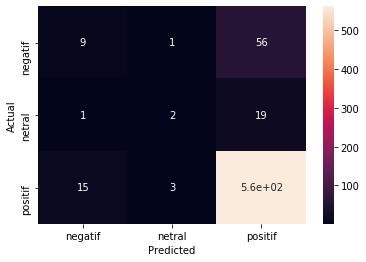

In [21]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [22]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# Create parameter grid
# {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# parameters = {"learning_rate": [0.001, 0.01, 0.1, 0.4],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10, 12],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0.001, 0.01, 0.025, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])